image_xyt data shape: (200, 256, 256)
Saved data to image_xyt.npy
k-space shape: (200, 256, 256)
Saved the computed k-space as 'k_space.npy'
In file - k_space.npy the k-space shape: (200, 256, 256)
Undersampled k-space - 'undersampled_k_space.npy'. shape is: (200, 256, 256)
Shape of bb: (51200, 32)
Outer loop iteration 1, alpha = 1000.0
Inner loop iteration 1
CG convergence info: 200
Relative change in Us_r: 13.358270069822401
Inner loop iteration 2
Relative change in Us_r: 0.10548447254390997
Inner loop iteration 3
Relative change in Us_r: 0.0
Outer loop iteration 2, alpha = 500.0
Inner loop iteration 1
Relative change in Us_r: 0.0
Outer loop iteration 3, alpha = 250.0
Inner loop iteration 1
Relative change in Us_r: 2.645981263214345e-05
Inner loop iteration 2
Relative change in Us_r: 0.0
Outer loop iteration 4, alpha = 125.0
Inner loop iteration 1
Relative change in Us_r: 0.0
Outer loop iteration 5, alpha = 62.5
Inner loop iteration 1
Relative change in Us_r: 0.0
Outer loop iteration

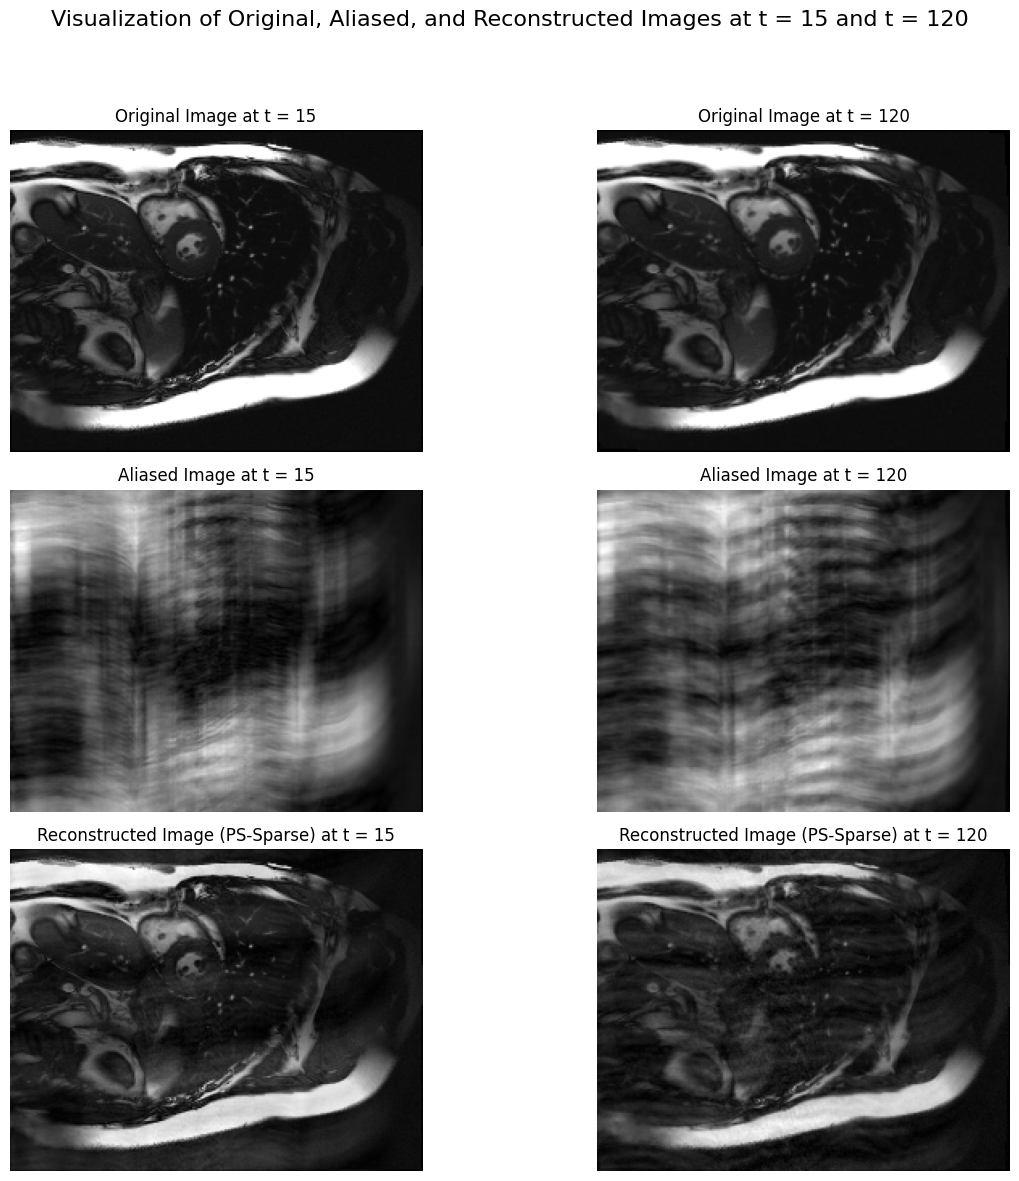

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fft, ifft, fftshift, ifftshift
from scipy.sparse import csr_matrix, coo_array
from scipy.sparse.linalg import cg, svds, LinearOperator
import cv2

# Data Loading and K-Space Generation

def convert_mat_to_npy(mat_filename, npy_filename):
    """
    Convert MATLAB .mat file to NumPy .npy file.
    
    Inputs:
    - mat_filename: Input .mat file path
    - npy_filename: Output .npy file path
    """
   
    mat_contents = scipy.io.loadmat(mat_filename)
    img_data = mat_contents['image_xyt']
    print("image_xyt data shape:", img_data.shape)
    np.save(npy_filename, img_data)
    print(f"Saved data to {npy_filename}")

def compute_k_space(input_file, output_file):
    """
    Compute k-space (2D FFT) for each frame of the image data.
    
    Inputs:
    - input_file: Input .npy file with image data (shape: (Np, Nf, Nfr))
    - output_file: Output .npy file for k-space data
    """
    img_data = np.load(input_file)
    k_space = fft2(img_data, axes=(0, 1))
    k_space = fftshift(k_space, axes=(0, 1))
    np.save(output_file, k_space)
    print("k-space shape:", k_space.shape)
    print(f"Saved the computed k-space as '{output_file}'")

# Deliverable 1: Sampling Mask Generation and Undersampling

def generate_temporal_mask(num_phase_encodes, num_frames, nav_encodes, num_samples):
    """
    Generate the temporal sampling mask.
    
    Inputs:
    - num_phase_encodes: Number of phase encodings (Np)
    - num_frames: Number of temporal frames (Nfr)
    - nav_encodes: Number of navigator encodings (Nnav)
    - num_samples: Number of samples per non-navigator line (Nsam)
    
    Output:
    - sampling_mask: Temporal sampling mask (shape: (Np, Nfr), boolean)
    """
    sampling_mask = np.zeros((num_phase_encodes, num_frames), dtype=bool)
    nav_start = num_phase_encodes // 2 - nav_encodes // 2
    nav_end = nav_start + nav_encodes
    sampling_mask[nav_start:nav_end, :] = True
    remaining_indices = np.setdiff1d(np.arange(num_phase_encodes), np.arange(nav_start, nav_end))
    for index in remaining_indices:
        random_samples = np.random.choice(num_frames, num_samples, replace=False)
        sampling_mask[index, random_samples] = True
    return sampling_mask

def apply_sampling_mask(k_space_file, output_file, num_phase_encodes=200, num_frames=256, nav_encodes=4, num_samples=10):
    """
    Apply the temporal sampling mask to generate undersampled k-space data.
    
    Inputs:
    - k_space_file: Input .npy file with full k-space data
    - output_file: Output .npy file for undersampled k-space data
    - num_phase_encodes, num_frames, nav_encodes, num_samples: Parameters for mask generation
    """
    k_space_data = np.load(k_space_file)
    print(f"In file - {k_space_file} the k-space shape:", k_space_data.shape)
    
    sampling_mask = generate_temporal_mask(num_phase_encodes, num_frames, nav_encodes, num_samples)
    mask_3d = sampling_mask[:, np.newaxis, :]  # Shape: (Np, 1, Nfr)
    undersampled_k_space = k_space_data * mask_3d
    
    np.save(output_file, undersampled_k_space)
    print(f"Undersampled k-space - '{output_file}'. shape is: {undersampled_k_space.shape}")
    return sampling_mask

def reconstruct_aliased_image(k_space_slice, transform_axes=(0, 1)):
    """
    Reconstruct aliased image from undersampled k-space data (for visualization).
    
    Inputs:
    - k_space_slice: Undersampled k-space data for a single frame (shape: (Np, Nf))
    - transform_axes: Axes for inverse FFT
    """
    shifted_k_space = ifftshift(k_space_slice, axes=transform_axes)
    reconstructed_image = ifft2(shifted_k_space, axes=transform_axes)
    return np.abs(reconstructed_image)

# Deliverable 2: Temporal Basis Estimation and PS-Sparse Reconstruction

def estimate_temporal_basis(undersampled_k_space, mask, Np, Nf, Nfr, Nnav, L):
    """
    Estimate the temporal basis (Vt_r) using the fully sampled central k-space data.
    
    Inputs:
    - undersampled_k_space: Undersampled k-space data (shape: (Np, Nf, Nfr), complex)
    - mask: Sampling mask (shape: (Np, Nfr), boolean)
    - Np, Nf, Nfr: Dimensions
    - Nnav: Number of navigator lines
    - L: PS model order (rank)
    
    Output:
    - Vt_r: Temporal basis (shape: (L, Nfr), complex)
    """
    nav_ind = np.arange(Np // 2 - Nnav // 2, Np // 2 + Nnav // 2)
    central_k_space = undersampled_k_space[nav_ind, :, :]  # Shape: (Nnav, Nf, Nfr)
    central_k_space_reshaped = np.reshape(central_k_space, (Nnav * Nf, Nfr), order='F')
    U, S, Vt = np.linalg.svd(central_k_space_reshaped, full_matrices=False)
    Vt_r = Vt[:L, :]  # Shape: (L, Nfr)
    return Vt_r.astype(np.complex64)

def normal_oper(Uk_r, Vt_r, Rind, Cind, Mask):
    """
    Normal operator for conjugate gradient solver.
    
    Inputs:
    - Uk_r: K-space representation of spatial basis (shape: (Np*Nf, L), complex)
    - Vt_r: Temporal basis (shape: (L, Nfr), complex)
    - Rind, Cind: Row and column indices of sampled points
    - Mask: Sampling mask (shape: (Np*Nf, Nfr), boolean)
    """
    N = Mask.shape[0]
    M = Mask.shape[1]
    r = Vt_r.shape[0]
    G = np.reshape(Uk_r, (N, r), order="F") @ Vt_r
    d = G[Mask]
    del G
    UU = coo_array((d, (Rind, Cind)), shape=(N, M)) @ Vt_r.conj().T
    UU = np.reshape(UU, (N * r), order="F")
    return UU

def soft_threshold(x, threshold):
    """
    Apply soft-thresholding for sparsity regularization.
    
    Inputs:
    - x: Input array
    - threshold: Threshold value
    """
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def ps_sparse_recon(d, Mask, Np, Nf, Nfr, Vt_r, mu=1e-3, alpha_init=1e3, alpha_final=1e-3, alpha_factor=0.5, max_iter_outer=10, max_iter_inner=100, tol=1e-5):
    """
    Perform PS-Sparse reconstruction.
    
    Inputs:
    - d: Measured data (undersampled k-space data, shape: (number of sampled points,))
    - Mask: k-t space sampling mask (shape: (Np*Nf, Nfr), boolean)
    - Np, Nf, Nfr: Dimensions
    - Vt_r: Temporal basis (shape: (L, Nfr), complex)
    - mu, alpha_init, alpha_final, alpha_factor: Regularization and continuation parameters
    - max_iter_outer, max_iter_inner, tol: Iteration and convergence parameters
    
    Output:
    - Us_r: Updated spatial subspace (shape: (Np*Nf, L), complex)
    """
    L = Vt_r.shape[0]
    Rind, Cind = np.nonzero(Mask)
    
    bb = coo_array((d, (Rind, Cind)), shape=(Np * Nf, Nfr)) @ Vt_r.conj().T
    print(f"Shape of bb: {bb.shape}")
    
    Us_r = np.random.randn(Np * Nf, L) + 1j * np.random.randn(Np * Nf, L)
    Us_r = Us_r.astype(np.complex64) / np.sqrt(Np * Nf)
    
    Uk_r = 1 / np.sqrt(Np * Nf) * np.reshape(fft2(np.reshape(Us_r, (Np, Nf, L), order="F"), axes=(0, 1)), (Np * Nf, L), order="F")
    Us_r_last = Us_r.copy()
    
    Vf_r = 1 / np.sqrt(Nfr) * np.fft.fft(Vt_r, axis=1)
    
    alpha = alpha_init
    for outer_iter in range(max_iter_outer):
        print(f"Outer loop iteration {outer_iter + 1}, alpha = {alpha}")
        beta = 1 / alpha
        
        for inner_iter in range(max_iter_inner):
            print(f"Inner loop iteration {inner_iter + 1}")
            
            Us_Vf = Us_r @ Vf_r
            Gs = soft_threshold(Us_Vf, 1 / beta) @ Vf_r.conj().T
            Gk = 1 / np.sqrt(Np * Nf) * np.reshape(fft2(np.reshape(Gs, (Np, Nf, L), order="F"), axes=(0, 1)), (Np * Nf, L), order="F")
            b = bb + mu * beta / 2 * Gk
            
            def funcd(x):
                result = normal_oper(x, Vt_r, Rind, Cind, Mask) + mu * beta / 2 * x
                return result
            
            A = LinearOperator((Np * Nf * L, Np * Nf * L), matvec=funcd)
            Uk_r, info = cg(A, b.flatten(order='F'), atol=tol, maxiter=200, x0=Uk_r.flatten(order='F'))
            if info != 0:
                print(f"CG convergence info: {info}")
            
            Uk_r = np.reshape(Uk_r, (Np * Nf, L), order="F")
            Us_r = np.sqrt(Np * Nf) * np.reshape(ifft2(np.reshape(Uk_r, (Np, Nf, L), order="F"), axes=(0, 1)), (Np * Nf, L), order="F")
            
            relchange_Us = np.linalg.norm(Us_r.flatten() - Us_r_last.flatten()) / np.linalg.norm(Us_r_last.flatten())
            print(f"Relative change in Us_r: {relchange_Us}")
            Us_r_last = Us_r.copy()
            if relchange_Us < tol:
                break
        
        alpha = alpha * alpha_factor
        if alpha < alpha_final:
            break
    
    return Us_r

# Main Script

def main():
    # Parameters
    Np = 200
    Nf = 256
    Nnav = 4
    Numfr = 2048
    Ng = 8
    Nfr = Numfr // Ng  # 256
    Nsam = 32  # Number of samples per non-navigator line
    L = 32  # PS model order (rank)
    
    # Deliverable 1: Convert .mat to .npy and compute k-space
    convert_mat_to_npy("image_xyt.mat", "image_xyt.npy")
    compute_k_space("image_xyt.npy", "k_space.npy")
    
    # Deliverable 1: Generate sampling mask and undersampled k-space
    sampling_mask = apply_sampling_mask("k_space.npy", "undersampled_k_space.npy", num_phase_encodes=Np, num_frames=Nfr, nav_encodes=Nnav, num_samples=Nsam)
    
    # Load data
    image_xyt = np.load('image_xyt.npy').astype(np.complex64)
    undersampled_k_space = np.load('undersampled_k_space.npy').astype(np.complex64)
    
    # Deliverable 2: Reshape undersampled k-space and mask for reconstruction
    undersampled_k_space_reshaped = np.reshape(undersampled_k_space, (Np * Nf, Nfr), order='F')
    Mask = np.zeros((Np * Nf, Nfr), dtype=bool)
    for t in range(Nfr):
        Mask[:, t] = np.tile(sampling_mask[:, t], Nf)
    d = undersampled_k_space_reshaped[Mask]
    
    # Deliverable 2: Estimate temporal basis (Vt_r)
    Vt_r = estimate_temporal_basis(undersampled_k_space, sampling_mask, Np, Nf, Nfr, Nnav, L)
    
    # Deliverable 2: Perform PS-Sparse reconstruction
    Us_r = ps_sparse_recon(d, Mask, Np, Nf, Nfr, Vt_r, mu=1e-3, alpha_init=1e3, alpha_final=1e-3, alpha_factor=0.5)
    
    # Deliverable 2: Reconstruct final image
    C = Us_r @ Vt_r  # Shape: (Np * Nf, Nfr)
    recon_pssp = np.reshape(C, (Np, Nf, Nfr), order='F')
    
    # Visualization: Original, Aliased, and Reconstructed Images
    selected_times = [14, 119]  # t = 15 and t = 120
    fig, subplot_axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 12))
    fig.suptitle('Visualization of Original, Aliased, and Reconstructed Images at t = 15 and t = 120', fontsize=16)
    
    # Original Images
    for i, time_index in enumerate(selected_times):
        subplot_axes[0, i].imshow(np.abs(image_xyt[:, :, time_index]), cmap='gray')
        subplot_axes[0, i].set_title(f'Original Image at t = {time_index + 1}')
        subplot_axes[0, i].axis('off')
    
    # Aliased Images (from undersampled k-space)
    for i, time_index in enumerate(selected_times):
        aliased_image = reconstruct_aliased_image(undersampled_k_space[:, :, time_index])
        subplot_axes[1, i].imshow(aliased_image, cmap='gray')
        subplot_axes[1, i].set_title(f'Aliased Image at t = {time_index + 1}')
        subplot_axes[1, i].axis('off')
    
    # Reconstructed Images (PS-Sparse)
    for i, time_index in enumerate(selected_times):
        subplot_axes[2, i].imshow(np.abs(recon_pssp[:, :, time_index]), cmap='gray')
        subplot_axes[2, i].set_title(f'Reconstructed Image (PS-Sparse) at t = {time_index + 1}')
        subplot_axes[2, i].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()

if __name__ == "__main__":
    main()